In [1]:
import os, glob
import numpy as np
import pandas as pd
import scanpy as sc
import scFates as scf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_attr = os.path.join(pth_data, 'modeling', 'interpret')
pth_traj = os.path.join(pth_data, 'trajectories')
pth_feat = os.path.join(pth_data, 'features', 'biomart')
pth_out = os.path.join(pth, 'figures', 'modeling', 'attributions')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_attr, 'training.h5ad'))
adata

AnnData object with n_obs × n_vars = 1573925 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 'training', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score'

In [4]:
feat_fn = sorted(glob.glob(os.path.join(pth_feat, '*.csv')))
df = pd.read_csv(os.path.join(pth_data, 'summary.csv'), index_col = 0)
get_source = lambda fn: os.path.split(fn)[1].replace('.csv', '')
feat_dict = {get_source(fn) : fn for fn in feat_fn if 'union' not in fn}
for src, fn in feat_dict.items():
    print(src)
    df_feat = pd.read_csv(fn)
    g = df_feat.mmusculus.copy()
    g = g.loc[g.isin(adata.var_names)]
    ig = adata[:, g].layers['IG_z'].sum(axis = 1)
    adata.obs[src] = np.asarray(ig).squeeze()

EMTHallmark
GSE136689
GSE162534
GSE201257
GSE229103
HCAEmbryonicHindlimb
rRNAModifications


In [5]:
cmap = 'RdBu_r'

EMTHallmark


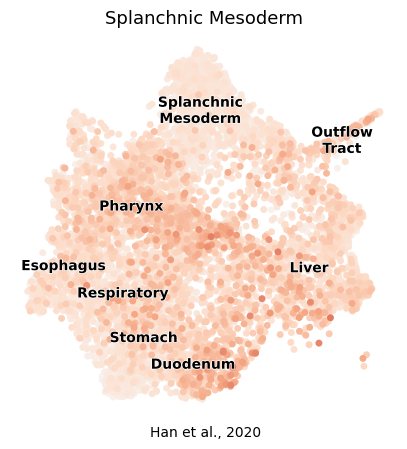

GSE136689


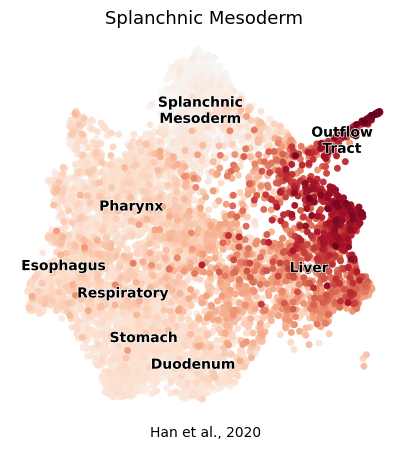

GSE162534


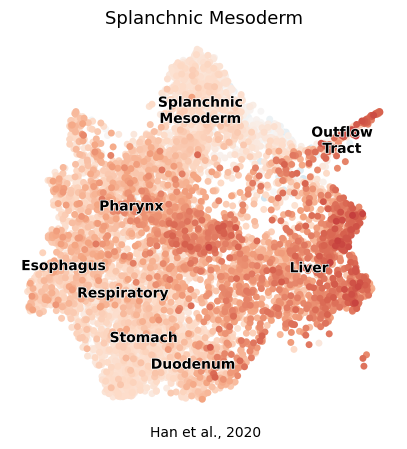

GSE201257


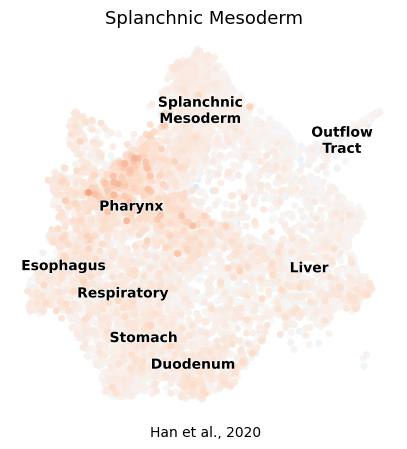

GSE229103


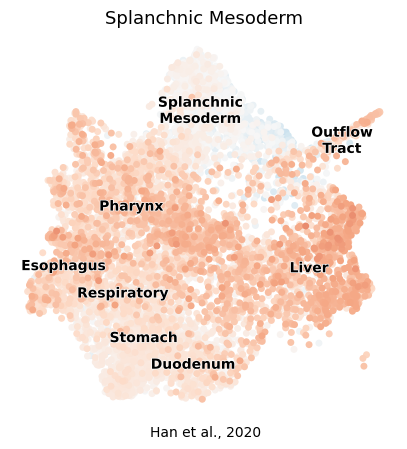

HCAEmbryonicHindlimb


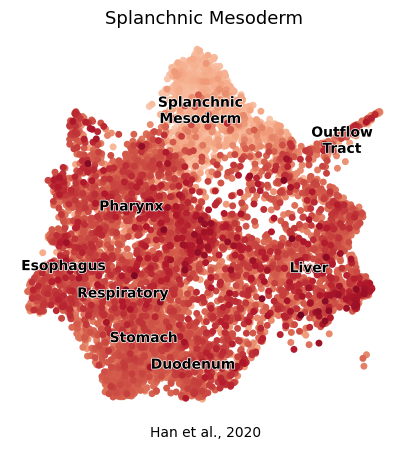

rRNAModifications


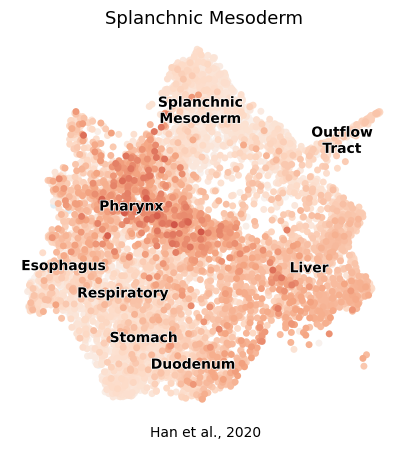

In [6]:
geo = 'GSE136689'
adata_plt = adata[adata.obs.source == geo].copy()
vmax = adata_plt.obs[feat_dict.keys()].abs().max().max()
vmin = -vmax

for src in feat_dict:
    print(src)
    fig, ax = plt.subplots(1, 1, figsize = (5, 5))
    sc.pl.embedding(adata_plt, 'X_draw_graph_fa', color = src,
                    size = 100, cmap = cmap, vmin = vmin, vmax = vmax,
                    frameon = False, colorbar_loc = None, show = False,
                    ax = ax)
    sc.pl.embedding(adata_plt, 'X_draw_graph_fa', color = 'celltype',
                    size = 100, alpha = 0, legend_loc = 'on data',
                    na_in_legend = False, legend_fontoutline = 1,
                    frameon = False, show = False, ax = ax)

    label_dict = {
        'Splanchnic Mesoderm' : 'Splanchnic\nMesoderm',
        'Outflow Tract'       : 'Outflow\nTract'}

    pos_dict = {
        'Splanchnic Mesoderm' : (0, 300),
        'Respiratory'         : (0, -300),
        'Outflow Tract'       : (5000, 800)}

    for label in ax.texts:
        _label_ = label.get_text()
        x, y = label.get_position()
        if _label_ in label_dict:
            label.set_text(label_dict[_label_])
        if _label_ in pos_dict:
            dx, dy = pos_dict[_label_]
            label.set_position([x + dx, y + dy])

    ax.set_title(df.loc[geo].Name, size = 13)
    ax.text(.36, -.05, df.loc[geo].Study, transform = ax.transAxes)
    # fn = os.path.join(pth_out, 'processed', geo, f'{src}.pdf')
    # plt.savefig(fn, bbox_inches = 'tight')
    plt.show()

EMTHallmark


/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


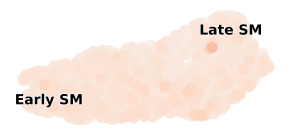

GSE136689


/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


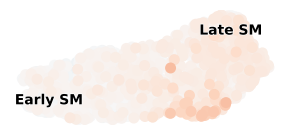

GSE162534


/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


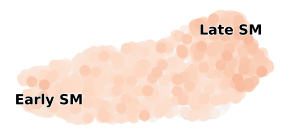

GSE201257


/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


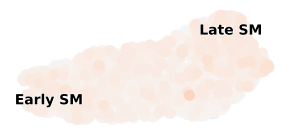

GSE229103


/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


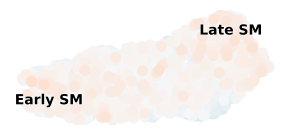

HCAEmbryonicHindlimb


/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


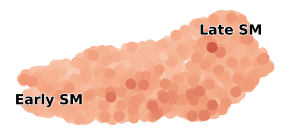

rRNAModifications


/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


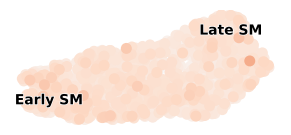

In [7]:
adata_traj = sc.read_h5ad(os.path.join(pth_traj, f'{geo}.h5ad'))

for src in feat_dict:
    print(src)
    adata_traj.obs[src] = adata_plt[adata_traj.obs_names].obs[src].copy()

    fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
    sc.pl.umap(adata_traj, color = src, cmap = cmap,
               vmin = vmin, vmax = vmax, size = 250,
               colorbar_loc = None, frameon = False,
               show = False, ax = ax)
    scf.pl.milestones(adata_traj, basis = 'umap',
                      annotate = True, alpha = 0,
                      show = False, ax = ax)
    ax.set_title('')
    # fn = os.path.join(pth_out, 'trajectories', geo, f'{src}.pdf')
    # plt.savefig(fn, bbox_inches = 'tight')
    plt.show()

EMTHallmark


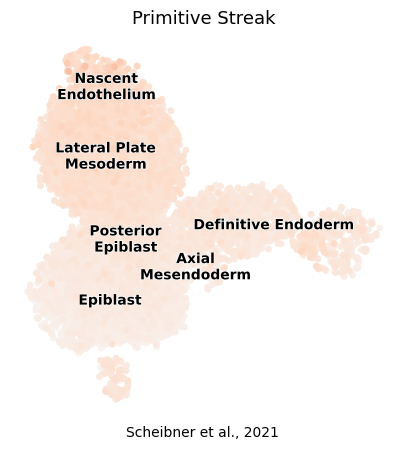

GSE136689


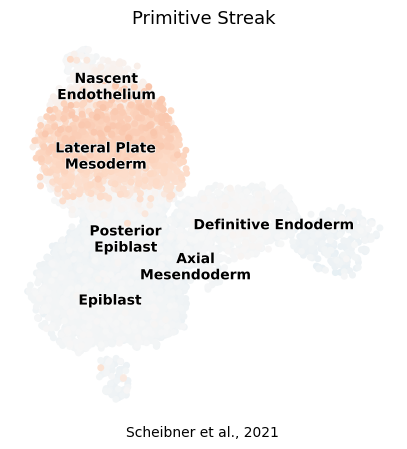

GSE162534


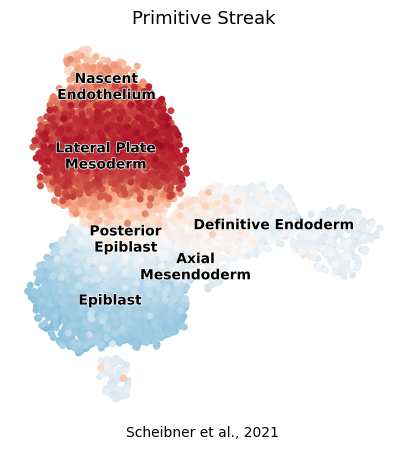

GSE201257


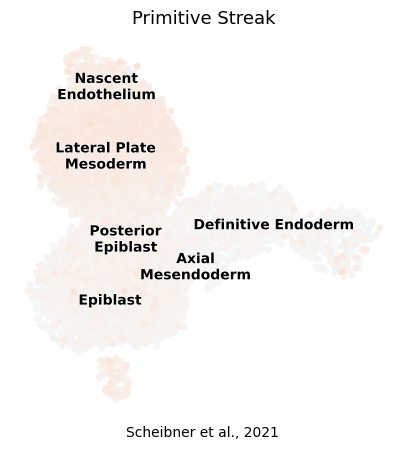

GSE229103


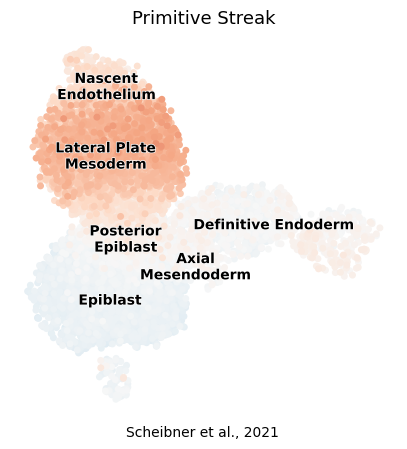

HCAEmbryonicHindlimb


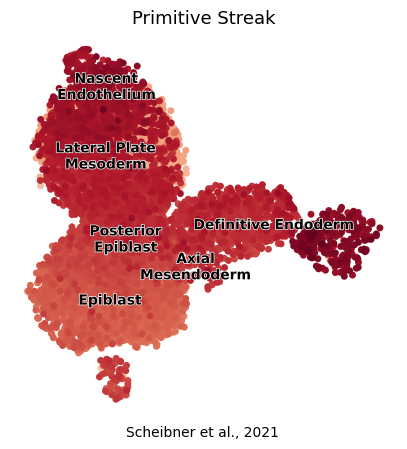

rRNAModifications


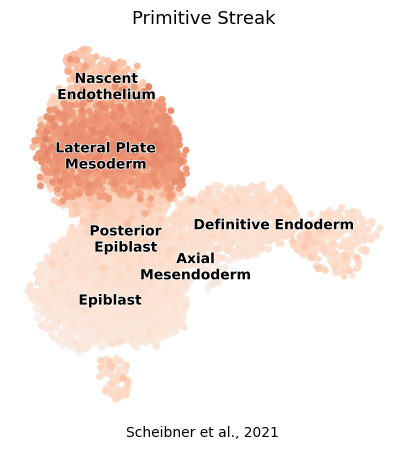

In [8]:
geo = 'GSE162534'
adata_plt = adata[adata.obs.source == geo].copy()
vmax = adata_plt.obs[feat_dict.keys()].abs().max().max()
vmin = -vmax

for src in feat_dict:
    print(src)
    fig, ax = plt.subplots(1, 1, figsize = (5, 5))
    sc.pl.umap(adata_plt, color = src, size = 100,
               cmap = cmap, vmin = vmin, vmax = vmax,
               frameon = False, colorbar_loc = None,
               show = False, ax = ax)
    sc.pl.umap(adata_plt, color = 'celltype', size = 100,
               alpha = 0, legend_loc = 'on data',
               na_in_legend = False, legend_fontoutline = 1,
               frameon = False, show = False, ax = ax)
    ax.invert_yaxis()

    label_dict = {
        'Nascent Endothelium'    : 'Nascent\nEndothelium',
        'Lateral Plate Mesoderm' : 'Lateral Plate\nMesoderm',
        'Posterior Epiblast'     : 'Posterior\nEpiblast',
        'Axial Mesendoderm'      : 'Axial\nMesendoderm'}

    pos_dict = {
        'Axial Mesendoderm'      : (.1, .2),
        'Posterior Epiblast'     : (-.2, 0),
        'Definitive Endoderm'    : (.5, 0)}

    for label in ax.texts:
        _label_ = label.get_text()
        x, y = label.get_position()
        if _label_ in label_dict:
            label.set_text(label_dict[_label_])
        if _label_ in pos_dict:
            dx, dy = pos_dict[_label_]
            label.set_position([x + dx, y + dy])

    ax.set_title(df.loc[geo].Name, size = 13)
    ax.text(.3, -.05, df.loc[geo].Study, transform = ax.transAxes)
    # fn = os.path.join(pth_out, 'processed', geo, f'{src}.pdf')
    # plt.savefig(fn, bbox_inches = 'tight')
    plt.show()

EMTHallmark


/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


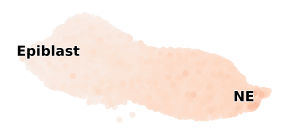

GSE136689


/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


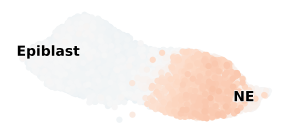

GSE162534


/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


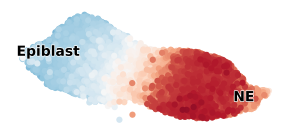

GSE201257


/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


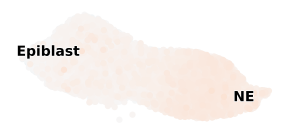

GSE229103


/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


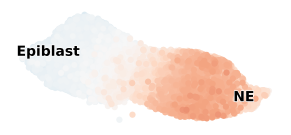

HCAEmbryonicHindlimb


/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


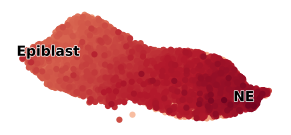

rRNAModifications


/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


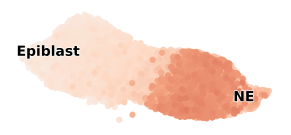

In [9]:
adata_traj = sc.read_h5ad(os.path.join(pth_traj, f'{geo}.h5ad'))
adata_traj = adata_traj[adata_traj.obs_names.isin(adata_plt.obs_names)].copy()

for src in feat_dict:
    print(src)
    adata_traj.obs[src] = adata_plt[adata_traj.obs_names].obs[src].copy()

    fig, ax = plt.subplots(1, 1, figsize = (3.5, 1.5))
    sc.pl.umap(adata_traj, color = src, size = 80,
               cmap = cmap, vmin = vmin, vmax = vmax,
               colorbar_loc = None, frameon = False,
               show = False, ax = ax)
    scf.pl.milestones(adata_traj, basis = 'umap',
                      annotate = True, alpha = 0,
                      show = False, ax = ax)
    ax.invert_xaxis(); ax.set_title('')

    label_dict = {
        'Lateral Plate Mesoderm' : 'NE',
        'Posterior Epiblast'     : 'Epiblast'}

    for label in ax.texts:
        _label_ = label.get_text()
        if _label_ in label_dict:
            label.set_text(label_dict[_label_])

    # fn = os.path.join(pth_out, 'trajectories', geo, f'{src}.pdf')
    # plt.savefig(fn, bbox_inches = 'tight')
    plt.show()

EMT Hallmark


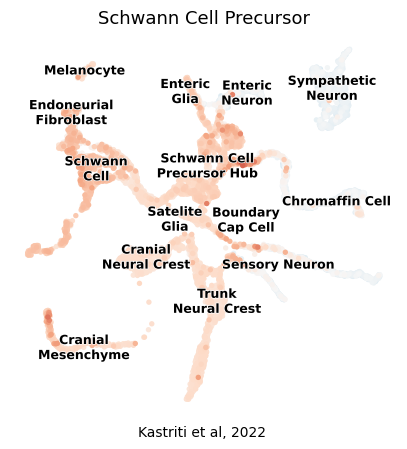

Splanchnic Mesoderm


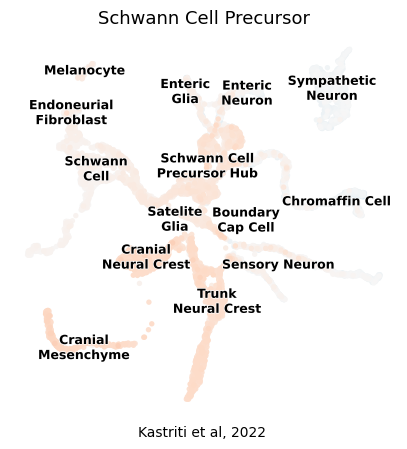

Primitive Streak


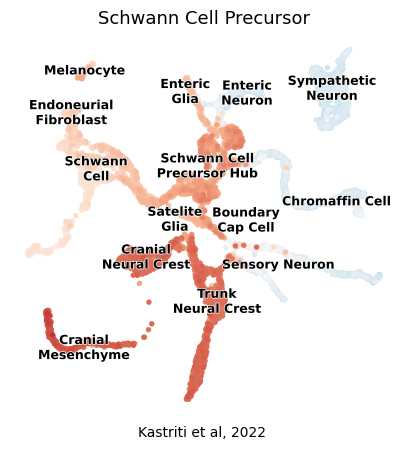

Schwann Cell Precursor


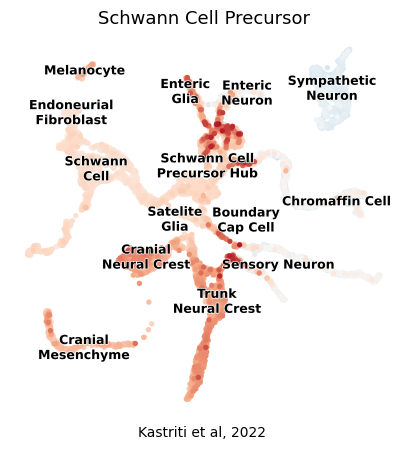

Neuromesodermal Progenitor


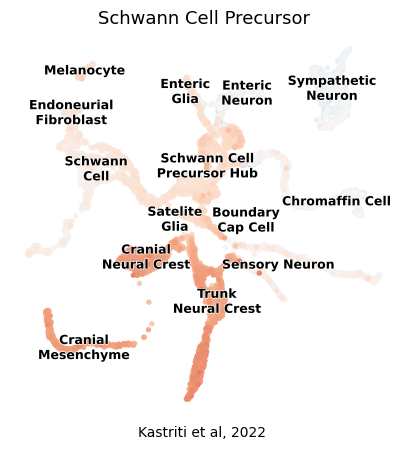

Embryonic Hindlimb


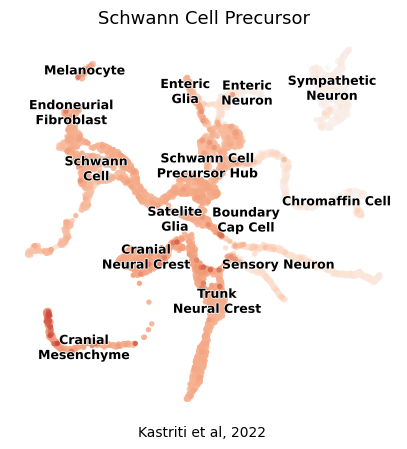

Cranial Neural Crest


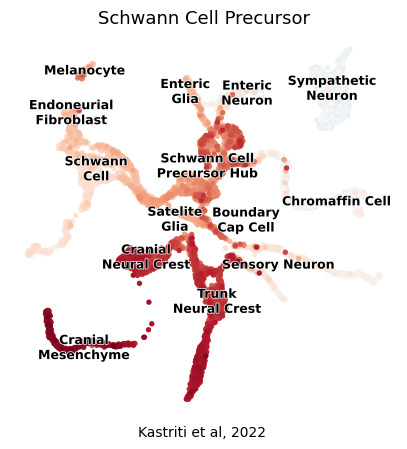

In [14]:
geo = 'GSE201257'
adata_plt = adata[adata.obs.source == geo].copy()
vmax = adata_plt.obs[feat_dict.keys()].abs().max().max()
vmin = -vmax

for src in feat_dict:
    print(df.loc[src].Name)
    fig, ax = plt.subplots(1, 1, figsize = (5, 5))
    sc.pl.umap(adata_plt, color = src, size = 60,
               cmap = cmap, vmin = vmin, vmax = vmax,
               frameon = False, colorbar_loc = None,
               show = False, ax = ax)
    sc.pl.umap(adata_plt, color = 'celltype', size = 60,
               alpha = 0, legend_fontsize = 9,
               legend_loc = 'on data', na_in_legend = False,
               legend_fontoutline = 1, frameon = False,
               show = False, ax = ax)

    label_dict = {
        'Endoneurial Fibroblast'     : 'Endoneurial\nFibroblast',
        'Sympathetic Neuron'         : 'Sympathetic\nNeuron',
        'Enteric Neuron'             : 'Enteric\nNeuron',
        'Enteric Glia'               : 'Enteric\nGlia',
        'Schwann Cell'               : 'Schwann\nCell',
        'Schwann Cell Precursor Hub' : 'Schwann Cell\nPrecursor Hub',
        'Cranial Neural Crest'       : 'Cranial\nNeural Crest',
        'Trunk Neural Crest'         : 'Trunk\nNeural Crest',
        'Cranial Mesenchyme'         : 'Cranial\nMesenchyme',
        'Satelite Glia'              : 'Satelite\nGlia',
        'Boundary Cap Cell'          : 'Boundary\nCap Cell'}

    pos_dict = {
        'Enteric Neuron'     : (1, 0),
        'Enteric Glia'       : (-.5, 0),
        'Schwann Cell'       : (.75, .75),
        'Trunk Neural Crest' : (1, .5),
        'Cranial Mesenchyme' : (1.75, -.5),
        'Satelite Glia'      : (-1.5, 0),
        'Boundary Cap Cell'  : (3, 0)}

    for label in ax.texts:
        _label_ = label.get_text()
        x, y = label.get_position()
        if _label_ in label_dict:
            label.set_text(label_dict[_label_])
        if _label_ in pos_dict:
            dx, dy = pos_dict[_label_]
            label.set_position([x + dx, y + dy])

    ax.set_title(df.loc[geo].Name, size = 13)
    ax.text(.33, -.05, df.loc[geo].Study, transform = ax.transAxes)
    # fn = os.path.join(pth_out, 'processed', geo, f'{src}.pdf')
    # plt.savefig(fn, bbox_inches = 'tight')
    plt.show()

In [ ]:
# # feature importance (ranks)
# rank = (pd.concat((
#         pd.DataFrame(
#             adata.layers['IG_z'].toarray(),
#             index = adata.obs_names,
#             columns = adata.var_names).abs(),
#         adata.obs.category), axis = 1)
#     .groupby('category').mean()
#     .rank(ascending = False, method = 'dense', axis = 1)
#     .astype(int))

In [ ]:
# # top features
# df = pd.DataFrame(index = np.arange(1, 101),
#                   columns = rank.columns)
# for ix in df.index:
#     df.loc[ix] = 100 * (rank <= ix).mean(axis = 0)
# auc = df.mean().sort_values(ascending = False)
# auc.head()

In [ ]:
# # plot features
# fig, ax = plt.subplots(1, 1, figsize = (4, 3.25))
# highlight = auc.head(3).sort_index().index
# ax.plot(df, c = 'lightgray', alpha = .25)
# df.loc[:, highlight].plot(ax = ax)
# ax.legend(bbox_to_anchor = (1., .66),
#           prop = {'style' : 'italic'},
#           frameon = False)
# ax.set_xlabel(r'Top-$k$ Feature')
# ax.set_ylabel('Cell Types (%)')
# ax.set_title('Feature Importance')
# fn = os.path.join(pth_out, 'attributions.pdf')
# plt.savefig(fn, bbox_inches = 'tight')